# Using Smart Cruise

This tutorial demonstrates how to use smart-cruise to find Pareto-optimal trajectories.

> **Note on Generality**: While this example uses aviation-style parameters (altitude, Mach speed),
> the underlying model is completely generic. It applies to any vehicle with state-dependent
> energy consumption: UAVs, AUVs (underwater vehicles), ground vehicles, ships, etc.
> See the main documentation for more details on adapting the model to other domains.

SC finds the Pareto front of energy/time optimal trajectories.
- Distance, height, and speeds are discrete. Finer granularity leads to better solutions.
- Speed is governed by a backoff parameter that tells when the vehicle can adjust speed.
- Energy ("weight") and time budgets are continuous.
- The default cost model is randomized, taking into account position, height, speed, remaining energy, and height change.
- For each internal state (distance, height, speed, backoff), a Pareto front is computed. The front is quantized for a trade-off between computation speed and solution quality.

In this tutorial notebook, we will investigate the impact of Pareto quantization on three scenario, then have a look at the best trajectories for the last scenario.

## Preparation

We will use Joblib to parallelize simulations with various quantization on a given scenario.

:::note
This tutorial uses `joblib` for parallelization. You can install it with:
```bash
pip install joblib
```
:::

The following cell chews all the work for us. It computes Pareto-optimal trajectories with various internal front quantizations.

In [1]:
from smart_cruise import CostRandom, Cruise
from joblib import Parallel, delayed
from functools import partial

pms = [2**i for i in range(9)][::-1]
n_s = 31


def traj_maker(pm, w0, t0):
    model = CostRandom(seed=42, n_s=n_s)
    cruise = Cruise(model)
    cruise.parameters.pareto_max = pm
    cruise.compute(w0=w0, t0=t0)
    return pm, cruise.trajectories


def pms_trajs(w0, t0):
    return Parallel(n_jobs=-1)(
        delayed(partial(traj_maker, w0=w0, t0=t0))(pm) for pm in pms
    )

## Tight budget

Let us start with a tight scenario (low weight and time budget):

In [2]:
res = pms_trajs(w0=22000.0, t0=22000.0)

Let's write a function to display the various results:

In [3]:
from matplotlib import pyplot as plt


def show_pareto(res, wmin=0, tmin=0):
    for pm, traj in res:
        if traj.trajs is None:
            continue
        w, t = traj.get_front()
        plt.plot(w, t, label=f"$q={pm}$")
    plt.xlabel("Remaining energy")
    plt.ylabel("Spare time")
    plt.xlim([wmin, None])
    plt.ylim([tmin, None])
    plt.legend()
    plt.show()

Let's look at the result!

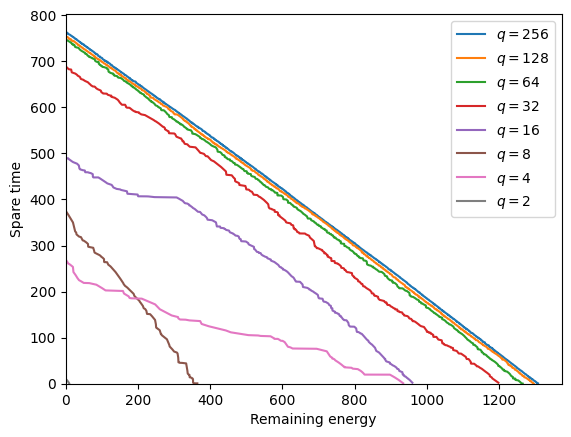

In [4]:
show_pareto(res)

What can be said here?
- Too much quantization and we fail to find solutions.
- Starting from 16, we have solutions. Their quality increases with the number of samples kept.

## Bigger budget

Now look at a scenario with overkill budget:

In [5]:
res = pms_trajs(w0=32000.0, t0=32000.0)

Let's look at the result!

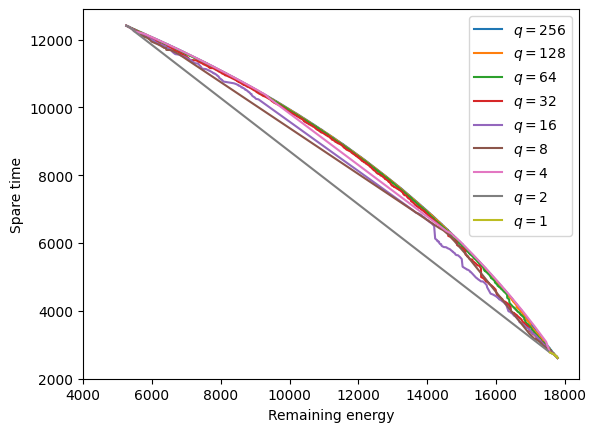

In [6]:
show_pareto(res, wmin=4000, tmin=2000)

- Strong quantization ($q\leq 16$) finds solutions but with poor quality.
- Low quantization seems to converge to the optimal Pareto front. $q=256$ seems to work fine!

## Middle budget

In [7]:
res = pms_trajs(w0=26000.0, t0=26000.0)

Let's look at the result!

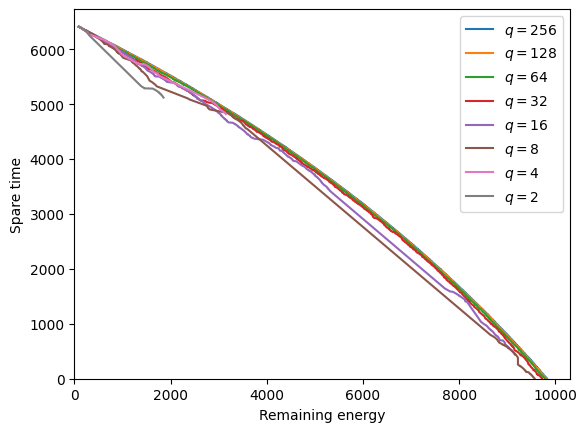

In [8]:
show_pareto(res)

Let's look at the result!

## Trajectories

Best weight preserving trajectory:

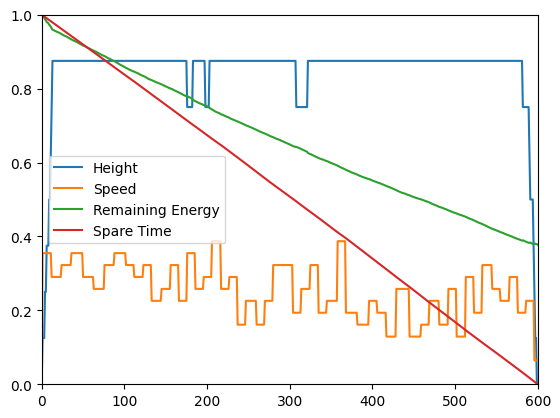

In [9]:
_, trajs = res[0]
trajs.plot_traj(0)

Best time preserving trajectory:

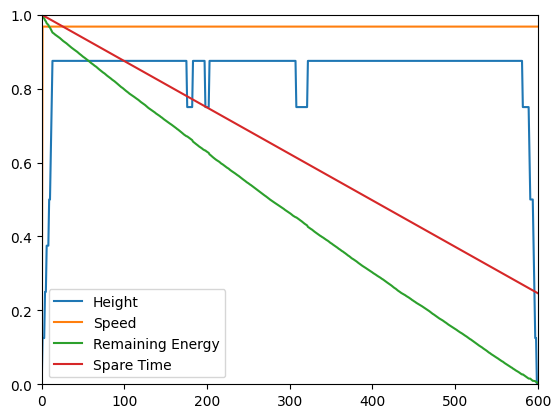

In [10]:
trajs.plot_traj(-1)

Balanced trajectory:

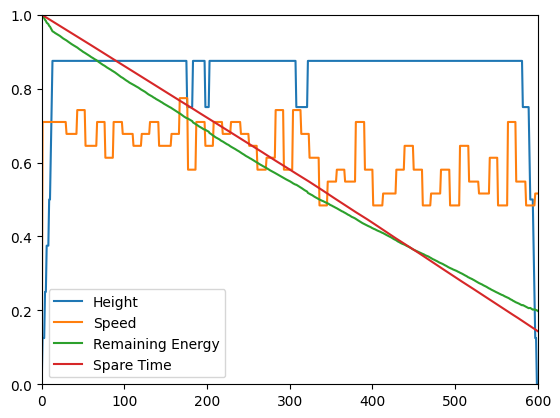

In [11]:
nt, _ = trajs.trajs.shape
trajs.plot_traj(nt // 2)